In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# фиксируем RANDOM_SEED, чтобы эксперимент был воспроизводим!
RANDOM_SEED = 42

## Подгружаем данные

In [2]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking'
df_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv') 
df_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv') 
sample_submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv') 

df_train['sample'] = 1    # =1 метка train 66,666%
df_test['sample'] = 0     # =0 метка test, НЕ train, 33,333%

hotels=df_test.append(df_train, sort=False).reset_index(drop=True) # соединяем таблицы

hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Обработка тегов

In [3]:
import operator
all_tags=dict()       # Создаем словарь
def unpack_list(a):   # Ищем считаем совпадения
    if type(a)==str:
        al=list(a[3:-3].split(" ', ' "))
        for element in al:
            if element in all_tags:
                all_tags[element]+=1
            else: all_tags[element]=1
        return(al)

hotels['unpack_tags']=hotels['tags'].apply(unpack_list)
# Сортируем тэги по полярности по убыванию
sorted_tuples  = sorted(all_tags.items(), key=operator.itemgetter(1),reverse=True)
all_tags_sorted = {k: v for k, v in sorted_tuples}

# Выделяем 25 самых популярных тегов
l25_items = list({k: all_tags_sorted[k] for k in list(all_tags_sorted)[:25]}.keys())

# Добавляем признаки популярных тегов
for tag in l25_items:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)
    
# Удаляем категориальный признак    
hotels=hotels.drop('tags',axis=1)

hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room,Superior Double or Twin Room,2 rooms,Stayed 6 nights,Standard Twin Room,Single Room
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,0,0,0,0,0


## Упорядочим отзывы, получим рейтинг:

In [4]:
#Хорошие в плохих или отсутствуют = 0, плохие = -1
positive_list=['it was all good','no thing','all ok','not a thing','all was good','non','leaving','having to leave','','no', 'na','no negative', 'all good','n a','none','nil','All was good', 'All good', ' ']
def unpack_negative_review(a):
    a=a.strip().lower()
    if a.find('nothing')>=0 or a.find('ything')>=0 or a in positive_list: return 0
    return -1
# Создаем рейтинговый столбец на базе анализа отзывов
hotels['rating']=hotels['negative_review'].apply(unpack_negative_review)
# Удаляем категориальный признак
hotels=hotels.drop('negative_review',axis=1)

#Плохие в хороших = 0, хорошие = 1
def unpack_positive_review(a):
    a=a.strip().lower()
    if a=='no positive': return 0
    return 1
# Складываем результаты, изменяем рейтинг 
hotels['rating']=hotels['rating']+hotels['positive_review'].apply(unpack_positive_review)
# Удаляем категориальный признак
hotels=hotels.drop('positive_review',axis=1)

hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room,Superior Double or Twin Room,2 rooms,Stayed 6 nights,Standard Twin Room,Single Room,rating
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,...,0,0,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,...,0,0,0,0,0,0,0,0,0,-1


Рейтинг показывает, что:
*     Отель, о котором отзываются положительно, имеет значение +1
*     Отель, о котором есть и положительные и отрицательные отзывы, или никаких - не изменяется
*     Отель, о котором отзываются отрицательно = -1

### Мультиколлинеарность 

<AxesSubplot:title={'center':'Корреляция'}>

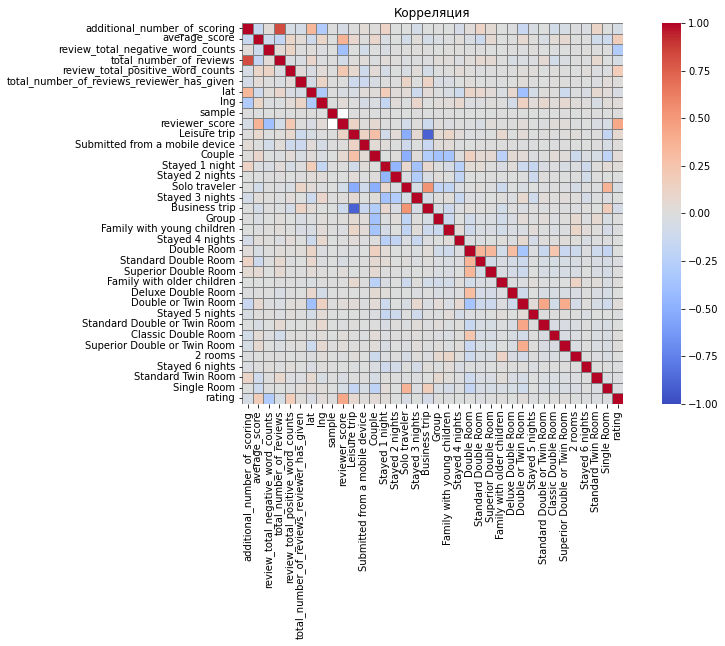

In [5]:
plt.figure(figsize = (14,7))
plt.title('Корреляция')
sns.heatmap(hotels.corr(), annot=False, square=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='gray')

In [6]:
# Удаляем тэги с сильной связью 
columns_for_delete=['Single Room','Double or Twin Room','Double Room','Solo traveler']
hotels.drop(columns_for_delete, axis = 1, inplace=True)

# убираем другие ненужные признаки 
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски
hotels = hotels.fillna(0)

In [7]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [8]:
#Делим данные 
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            
X = train_data.drop(['reviewer_score'], axis=1)

In [9]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 33% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

In [10]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics                        # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [11]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1354407540086937


In [12]:
# Сабмиттим данные
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)